# Parallel K-Means Clustering Algorithm on Spark

Author: **Giorgio Polla**  
Date: **21/11/2019**  

Implementation of the K-Means clustering algorithm on Spark, with Python.  
The algorithm is tested:  
* using generated data;  
* using the famous Iris dataset (available on Kaggle at https://www.kaggle.com/uciml/iris), and against Sklearn's implementation of K-Means.  



### Libraries and constants

Import of the following libraries:  
* `time` to track the time performance of the implementation;  
* `pyspark` to utilize *Spark*;  
* `pandas` to manipulate dataframes for the sklearn comparison;
* `numpy` to easily operate with number arrays;  
* `matplotlib` to plot graphs;
* `operator.itemgetter` to easily sort the centroids.  

Moreover, some operative constants used in the following are defined, regarding input and output paths and formats, and the maximum number of workers and partitions utilised by _Spark_.

In [1]:
import time
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

FILE_PATH = '../data/iris'
OUT_PATH = '../out/'
IMG_FORMAT = 'png'
N_WORKERS = 8

POINTS_PER_CLUSTER=100
BASE_POINTS = [
    (1,2),
    (3,4),
    (-5,3)
]

The two following functions are used to generate random points starting from some base points, and a distribution (here a gaussian of mean 1 and standard deviation **std** customisable by the user.

In [2]:
def generate_points(
    n_points=POINTS_PER_CLUSTER,
    base_points=BASE_POINTS,
    std=0.3
):
    # Centroids computed by K-means should match base_points
    points=[]
    for i in base_points:
        for j in range(n_points):
            p = (
                i[0]*np.random.normal(1, std),
                i[1]*np.random.normal(1, std)
            )
            points.append(np.array(p))
    points=np.array(points)
    
    return base_points, points

def rdd_from_points(points):
    rdd = sc.parallelize(points).cache()
    return rdd

### File reading
The dataset is loaded as an RDD, using the `textFile()` function.  
The RDD is then manipulated in order to have each record divided in a features array ( gathered in **rdd_x**), and a label (grouped in **rdd_y)**.

In [3]:
def read_file(file_path):
    rdd = sc.textFile(file_path)
    
    rdd = rdd.map(
        lambda x:
            x.split()
    )
    
    rdd_x = rdd.map(
        lambda x: 
            np.array([float(el) for el in x[:-1]])
    )
    
    rdd_y = rdd.map(
        lambda x:           
            x[-1]
    )
    return rdd_x, rdd_y

### Standardisation
Each row of the RDD is standardised; this is done by first obtaining the mean for each column, then obtaining the standard deviation for them, and finally applying the standardisation formula.  

In [4]:
def standardise(rdd):    
    n_rows = rdd.count()
    
    col_sum = rdd.reduce(
        lambda x, y:
            [sum(el) for el in zip(x, y)]
    )
    mean = np.divide(col_sum, n_rows)
    
    variance = rdd.map(
        lambda x: np.square(x - mean)
    ).reduce(
        lambda x, y:
            [sum(el) for el in zip(x, y)]
    )
    std_dev = np.sqrt(np.divide(variance, n_rows))
    
    rdd = rdd.map(
        lambda x:
            np.divide((x - mean), std_dev)
    )
    
    return rdd

### Clustering process
The clustering follows the typical K-Means fashion, with some adjustments to exploit the Spark parallelisation.  
It is worth noting that the notation is consistent, and in particular:  
* **rdd** is an RDD containing the records on operate the clustering;
* **k** is the number of cluster setted to identify;  
* **c** is a centroid (float array);  
* **x** is the feature array of one data point (float array);  
* **centroids** is the array of centroids (array of **c**);  

In the first section there are the support functions for the proper clustering phase.  
* `init_rdd()` intialises the rdd, assigning every record to the fake cluster *-1*;  
* `init_centroids()` calculates and returns the intialised centroid array of **c**, either extracting random records from the rdd, or exctracting the first **k** records, depending on the user preferences;  
* `calc_distance()` calculates the distance between a centroid **c** and a data point which features are in **x**; now only the *'euclidean'* distance is implemented;  
* `assign_cluster()` calculates the appropriate cluster for a data point which features are in **x**, according to its distance to the current **centroids**;  
* `refine_clusters()` assigns every element of an **rdd** to a specific cluster, according to the current **centroids**;  
* `calculate_centroids()` calculates the position of the new centroids, by taking the mean position of all the elements in the **rdd** belonging to a specific cluser.  
* `cluster_variance()` calculates the cumulative distance of every data point in the **rdd** with respect to the centroid of the cluster it belongs to.  

**Note**: the distance selection, due to the many steps required until the reaching of the actual `calc_distance()` function, is passed as an additional argument in the previous functions.

In [5]:
def init_rdd(rdd):
    rdd = rdd.map(
        lambda x: (
            -1,
            x
        )
    )
    return rdd


def init_centroids(rdd, k, random=True):
    if random:
        return rdd.takeSample(False, k)
    return rdd.take(k)
    
    
def calc_distance(c, x, dist_type='euclidean'):
    if dist_type == 'euclidean':
        return np.linalg.norm(c - x)
    else:
        raise Exception('Distance Type not recognized.')
        sys.exit()
    
    
def assign_cluster(centroids, x, dist_type):
    distances = [calc_distance(c, x, dist_type=dist_type) for c in centroids]
    min_index = np.argmin(distances)    
    return min_index


def redefine_clusters(rdd, centroids, dist_type):
    rdd = rdd.map(
        lambda x: (
            assign_cluster(centroids, x[1], dist_type),
            x[1]
        )
    )
    return rdd

    
def calculate_centroids(rdd):
    centroids = rdd.map(
        lambda x: (
            x[0], (
                x[1],
                1
            )
        )
    ).reduceByKey(
        lambda x, y: (
            x[0] + y[0],
            x[1] + y[1]
        )
    ).map(
        lambda x: (
            x[0],
            x[1][0] / x[1][1]
        )
    ).collect()
    
    centroids = [el[1] for el in sorted(centroids, key=itemgetter(0))]
    return np.array(centroids)


def cluster_tot_distance(rdd, centroids, dist_type):
    distance = rdd.map(
        lambda x: 
            calc_distance(centroids[x[0]], x[1], dist_type)
    ).reduce(
        lambda x, y:
            x + y
    )
    
    return distance    

The proper clustering process takes the additional parameters:  
* **iterations**, the maximum number of iterations to go though;
* **tolerance**, the minimum cumulative distance the centroids have to move in a single iteration to not interrupt the process;  
* **n_init**, the number of initialisations to repeat;  
* **random_init**, deciding whether to randomly initialise the centroids. If set to *False*, for obvious reasons **n_init** is set to one.
* **distance_metric** between centroids and data points. Right now only *'euclidean'* is implemented;
* **verbose**, influencing the amount of information printed during the process;
* **collect_results** is a flag to decide whether or not to collect in an array the final cluster labels. This is intoduced to allow the graphical comparison with the sklearn results at the end, for the small iris dataset. **DO NOT** collect results for big datasets: that would lead in the best case to a significant slowing of the processing, and may cause serious memory issues.

The clusteiring phase proceeds inside the main iteration loop by redifing the clusters according the the current centroids, the calculating the new centroids according to the previous clusterisation. If the distance between the new and the old clusters is below the **tolerance** threshold, the process is considered converged and the loop in exited.  

Another external loop manages how many times the whole process is to be repeatd, with different initializations. At each step, the cumulative distance, the predicted array and the centroid position is recorded and at the end only the ones related to the initialisation with less cuulative distance are returned.

In [6]:
def k_means(rdd_x, k, iterations=20, tolerance=0.001, 
            n_init=5, random_init=True, 
            distance_metric='euclidean', verbose=False,
            collect_results=False
           ):
    if k > rdd_x.count():
        print('Invalid K: too big!')
        return
    print('Starting: %d inits\n' % 
          (n_init))
    init_time = time.time()
    cent_arr = []
    distance_arr = []
    
    if collect_results:
        y_arr = []
        
    if random_init == False:
        n_init = 1
    
    for trial in range(n_init):
        start_time = time.time()

        centroids = init_centroids(rdd_x, k, random=random_init)
        rdd = init_rdd(rdd_x)
        n_rows = rdd.count()
        for it in range(iterations):
            rdd = redefine_clusters(rdd, centroids, distance_metric)

            new_centroids = calculate_centroids(rdd)
            
            delta = np.linalg.norm(
                new_centroids - centroids[:len(new_centroids)]
            )
            
            if (delta < tolerance):
                print('%d. Converged.\t|\t' % (trial + 1), end='')
                break
            centroids = new_centroids

        # RDD collected only for displaying purposes!
        # This collect is done to later efficiently plot the clustering results, 
        # since the amount of data we have is small enough.
        # This collect is not part of the algorithm mechanics!
        if collect_results:
            y = rdd.map(
                lambda x:
                    x[0]
            ).collect()
            
            y_arr.append(y)
        
        total_time = time.time() - start_time
        cent_arr.append(centroids)
        distance_arr.append(cluster_tot_distance(rdd, centroids, distance_metric))
        print('Total distance: %0.2f\t|\tTime: %0.2fs' % 
              (distance_arr[-1], total_time)
        )
    
    index = np.argmin(distance_arr)
    finish_time = time.time() - init_time
    
    print('\nFinished in %0.2f s.\t|\tChosen init %d.' %
          (finish_time, (index + 1)))
    if verbose:
        [print('Cluster %d: %d' % (n, y.count(n))) \
            for n in sorted(np.unique(y))]
    
    if collect_results:
        ret = (y_arr[index], cent_arr[index], finish_time)
    else:
        ret = (cent_arr[index], finish_time)
        
    return ret

### Clustering Execution
The following code starts the _Spark_ context with the proper number of workers, reads the file and standardises the records.  

Afterwards, the clustering algorithm is run.

In [7]:
if 'sc' in locals():
    print('Restarting Spark Context...')
    sc.stop()
else:
    print('Initialising Spark Context...')
sc = pyspark.SparkContext('local[' + str(N_WORKERS) + ']')
print('Done.')

Initialising Spark Context...
Done.


In [13]:
base_points, points = generate_points(3000)

rdd = sc.parallelize(points).cache()

# Standardisation is not needed, since all the points are generated from
# the same normal distrubtion (same mean and especially same standard 
# deviation). Points are, as a consequence, distributed with the same
# variance (ideally) in the dimensions of the feature space. The feature
# space isotropy of K-Means is then not a problem.
# Usually, standardization would be advisable.

ctrds, tot_time = k_means(rdd, 3, random_init=True)

print('\nK-Means centroids:\n' + str(ctrds))
print('\nReal centroids:\n' + str(base_points))

Starting: 5 inits

1. Converged.	|	Total distance: 9943.27	|	Time: 6.21s
2. Converged.	|	Total distance: 9943.40	|	Time: 4.21s
3. Converged.	|	Total distance: 9943.40	|	Time: 6.14s
4. Converged.	|	Total distance: 13402.25	|	Time: 7.44s
5. Converged.	|	Total distance: 9943.40	|	Time: 4.20s

Finished in 33.18 s.	|	Chosen init 1.

K-Means centroids:
[[ 3.1058562   4.22957917]
 [-5.04130566  3.0270137 ]
 [ 1.09052756  2.06100662]]

Real centroids:
[(1, 2), (3, 4), (-5, 3)]


### Sklearn K-Means Comparison
Here is executed the comparison with the results obtained by the K-Means implementation available in the Sklearn library.  
Here the parallelized version of the algorithm is executed.

In [9]:
rdd_x, rdd_y = read_file(FILE_PATH)
rdd_x = standardise(rdd_x)

y, ctrds, tot_time = k_means(
    rdd_x, 
    3, 
    random_init=True, 
    collect_results=True
)

Starting: 5 inits

1. Converged.	|	Total distance: 129.89	|	Time: 1.80s
2. Converged.	|	Total distance: 129.89	|	Time: 1.15s
3. Converged.	|	Total distance: 129.89	|	Time: 1.90s
4. Converged.	|	Total distance: 129.95	|	Time: 2.13s
5. Converged.	|	Total distance: 129.95	|	Time: 1.99s

Finished in 9.44 s.	|	Chosen init 1.


The file is read again, this time using *Pandas*, and the clustering algorithm is applied.  
The results are then plotted in the space composed by the first two features.

0: 52, 1: 50, 2: 48


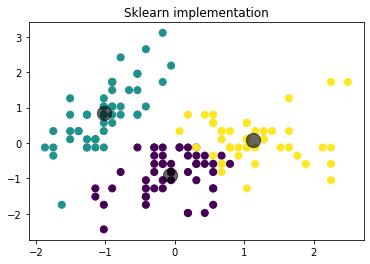

In [10]:
from sklearn import preprocessing
from sklearn.cluster import KMeans

df = pd.read_csv(FILE_PATH + '.csv').iloc[:,:-1]
x = df.values
standard_scaler = preprocessing.StandardScaler()
x = standard_scaler.fit_transform(x)

km = KMeans(n_clusters=3)
km.fit(x)
y_kmeans = km.predict(x)

plt.title('Sklearn implementation')
plt.scatter(x[:, 0], x[:, 1], c=y_kmeans, s=50, cmap='viridis')
ys = list(y_kmeans)
print('0: %2d, 1: %2d, 2: %2d' % (ys.count(0), ys.count(1), ys.count(2)))

centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.6);

Here the results of the Spark K-Means algorithm are plotted, in order to have a meaningful graphical comparison with the results above.

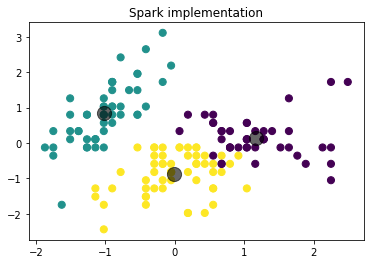

In [11]:
plt.title('Spark implementation')
plt.scatter(x[:, 0], x[:, 1], c=y, s=50, cmap='viridis')
plt.scatter(ctrds[:, 0], ctrds[:, 1], c='black', s=200, alpha=0.6);

As shown, the results are very similar, both regarding the position of the centroids and, of course, the clasification of the data points.  

Finally, the cumulative distance of the Spark and K-Means centroids is calculated and printed.

In [12]:
centr_sklearn = np.array(sorted(centers, key=itemgetter(0)))
centr_this = np.array(sorted(ctrds, key=itemgetter(0)))
                       
print('Total centroid distance error: %0.4f' %
       np.sum(abs(centr_this - centr_sklearn)))

Total centroid distance error: 0.2847


End.